##Predicting Crashes in Financial Markets - Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import pickle
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os
from prepare_data import DataLoader
from evaluate_results import EvaluateResults

In [2]:
# -------------------- Data preparation -------------------- #
os.chdir('/content/data')
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
# crashes according to Jacobsson:
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344]
# crashes according to Sornette:
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264]
months = [1, 3, 6]   # <-- predict if crash n months ahead (use: 1, 3 or 6)
data = DataLoader(datasets_original, dataset_names)
datasets_revised, crashes = data.get_data_revised(crash_thresholds)
dfs_x, dfs_y = data.get_dfs_xy(months=months)

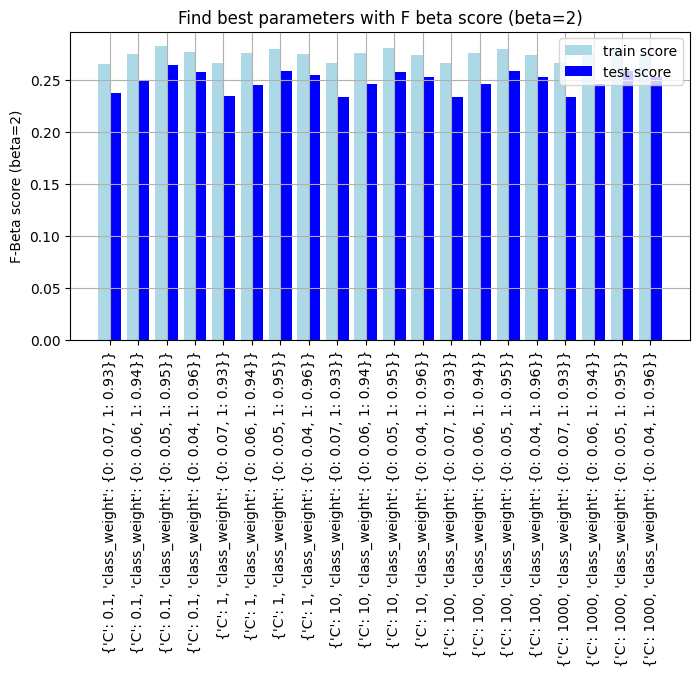

In [3]:
# -------------------- Find best parameters with grid search -------------------- #
model_name = 'Logistic Regression'
test_data = 'S&P 500'
month_prediction = 3
beta = 2

index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
x_train, y_train, _, _ = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=None)
y_train = y_train[:, index_month].astype(int)

# Find parameters with grid search:
fbeta_scorer = make_scorer(fbeta_score, beta=beta)
# param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.05, 1:.95}, {0:.04, 1:.96}, \
#               {0:.03, 1:.97}, {0:.025, 1:.975}, {0:.02, 1:.98}]}]   # <-- 1 month
param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.07, 1:.93}, {0:.06, 1:.94}, \
                {0:.05, 1:.95}, {0:.04, 1:.96}]}]   # <-- 3 months
# param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.11, 1:.89}, {0:.1, 1:.9},\
#                 {0:.09, 1:.91}, {0:.08, 1:.92}]}]   # <-- 6 months

clf = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid, scoring=fbeta_scorer, return_train_score=True)
model = clf.fit(x_train, y_train)
labels = model.cv_results_['params']
tr_score = model.cv_results_['mean_train_score']
t_score = model.cv_results_['mean_test_score']
rcParams['figure.figsize'] = 8, 4
plt.bar(x=np.arange(len(tr_score)) - 0.2,width=0.4, height=tr_score, color='lightblue', label='train score')
plt.bar(x=np.arange(len(t_score)) + 0.2,width=0.4, height=t_score, color='blue', label='test score')
plt.title('Find best parameters with F beta score (beta=2)')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.ylabel('F-Beta score (beta=2)')
plt.legend()
plt.grid()
plt.show()

In [4]:
# -------------------- Train Logistic Regression -------------------- #
class_weight = {0:.06, 1:.94}
C = 1
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    x_train, y_train, x_val, y_val = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=val_data)
    y_train, y_val = y_train[:, index_month].astype(int), y_val[:, index_month].astype(int)
    y_train_all.append(y_train)
    y_val_all.append(y_val)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    clf = linear_model.LogisticRegression(C=C, class_weight=class_weight)
    model = clf.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(x_val)
    y_pred_val_all.append(y_pred_val)

Train Logistic Regression - validation data: N225
Train Logistic Regression - validation data: SSE
Train Logistic Regression - validation data: HSI
Train Logistic Regression - validation data: BSESN
Train Logistic Regression - validation data: SMI
Train Logistic Regression - validation data: BVSP


In [5]:
# -------------------- Evaluate results -------------------- #
eval_ = EvaluateResults(y_train_all, y_val_all, y_pred_train_all, y_pred_val_all, model_name, test_data)
beta = 2
threshold = None
print(model_name)
print('\n')
print('Predict crash in:               ' + str(month_prediction) + ' months')
print('Number of features:             ' + str(dfs_x[0].shape[1]))
print('Number of rows in training set: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

Logistic Regression


Predict crash in:               3 months
Number of features:             16
Number of rows in training set: 47808


Results for each train/val split:
                       N225   SSE   HSI  BSESN   SMI  BVSP
positive actual train  0.03  0.04  0.04   0.04  0.04  0.04
positive pred train    0.10  0.11  0.12   0.11  0.10  0.13
precision train        0.16  0.12  0.13   0.13  0.12  0.12
recall train           0.46  0.37  0.39   0.40  0.34  0.39
accuracy_train         0.90  0.88  0.87   0.88  0.89  0.86
score_fbeta train      0.33  0.26  0.28   0.28  0.25  0.27
positive actual val    0.05  0.03  0.03   0.04  0.05  0.01
positive pred val      0.12  0.12  0.12   0.11  0.09  0.09
precision val          0.08  0.16  0.10   0.10  0.19  0.10
recall val             0.22  0.64  0.38   0.27  0.36  0.79
accuracy val           0.85  0.89  0.87   0.88  0.89  0.92
score fbeta val        0.16  0.40  0.24   0.20  0.31  0.34


Results - average over all train/val splits:
Positive train

In [6]:
# -------------------- Test model -------------------- #
x_train, y_train, x_test, y_test = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data=test_data)
y_train, y_test = y_train[:, index_month].astype(int), y_test[:, index_month].astype(int)
lm = linear_model.LogisticRegression(C=C, class_weight=class_weight)
model = lm.fit(x_train, y_train)
y_pred_test_bin = model.predict(x_test).astype(int)
threshold = None
_ = eval_.test_results(y_test, y_pred_test_bin, threshold, beta=beta)

Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.12
Precision test (model/random):      0.16 / 0.04
Recall test (model/random):         0.44 / 0.12
Accuracy test (model/random):       0.88 / 0.85
Score test fbeta:                   0.33 / 0.09


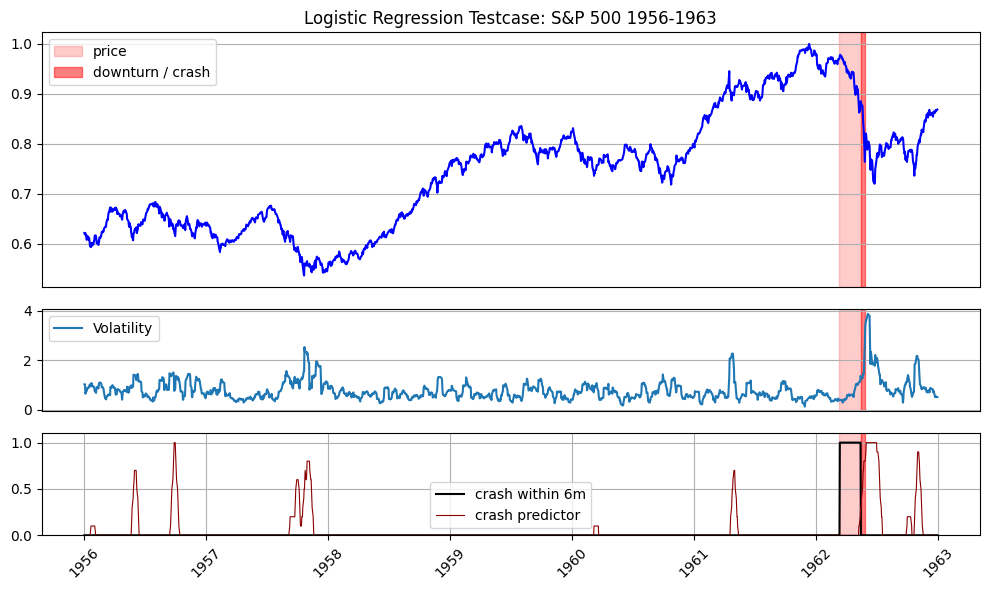

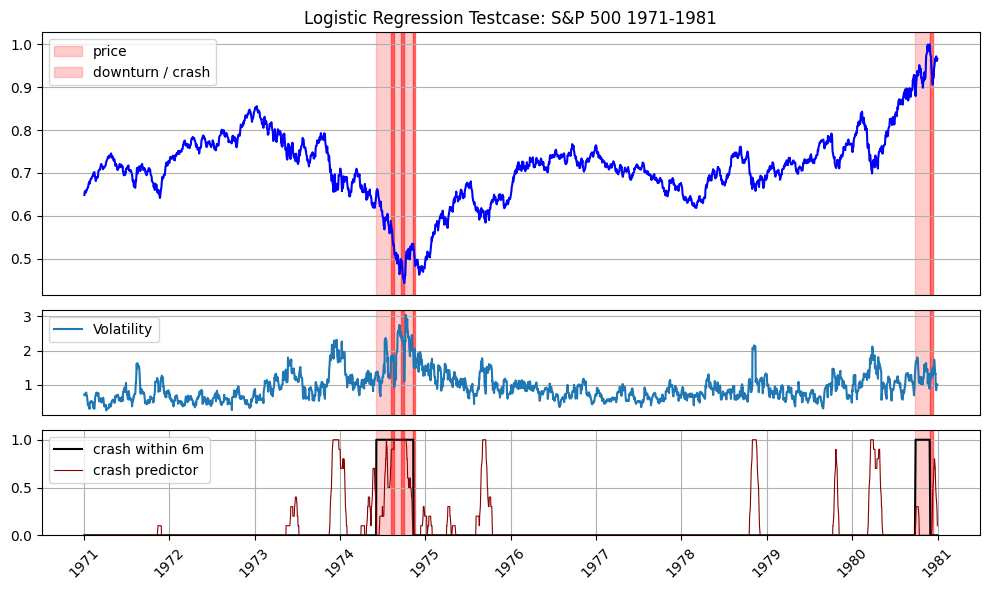

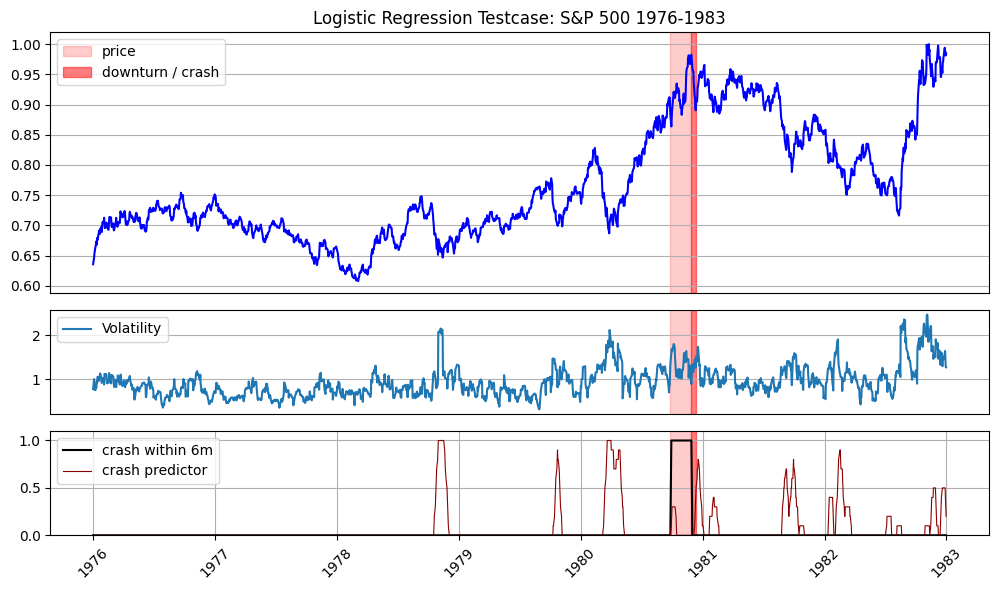

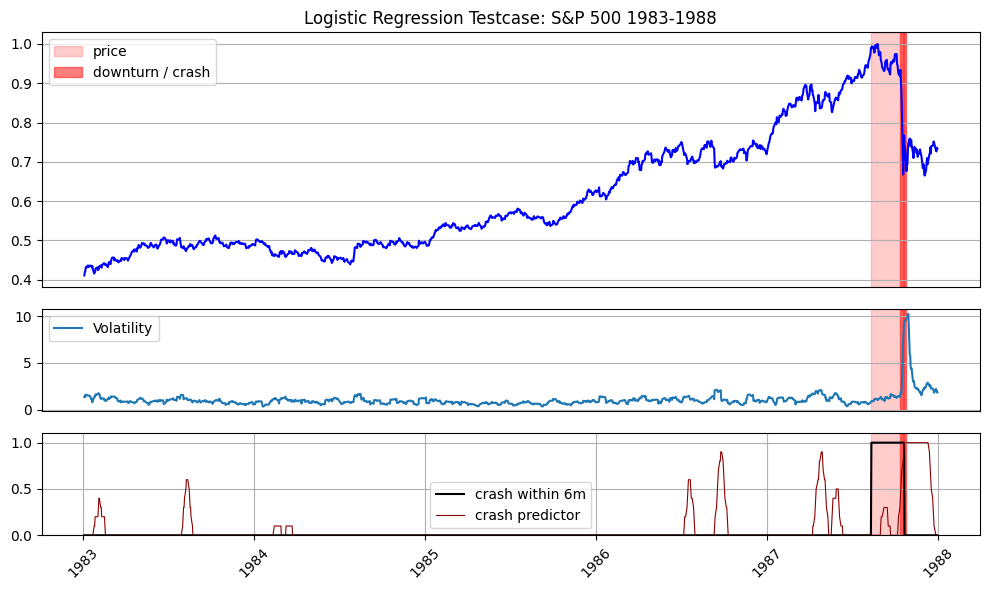

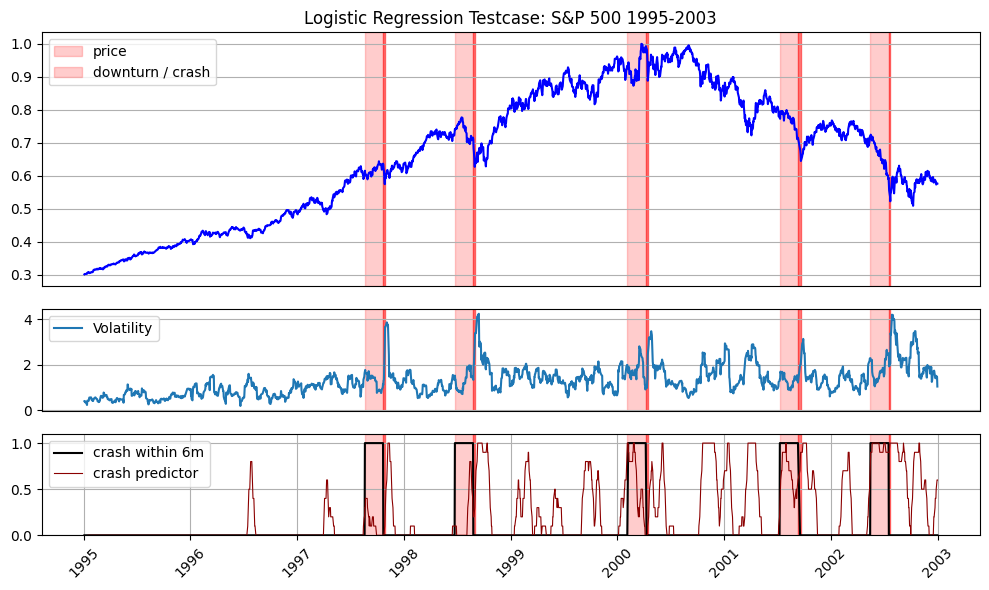

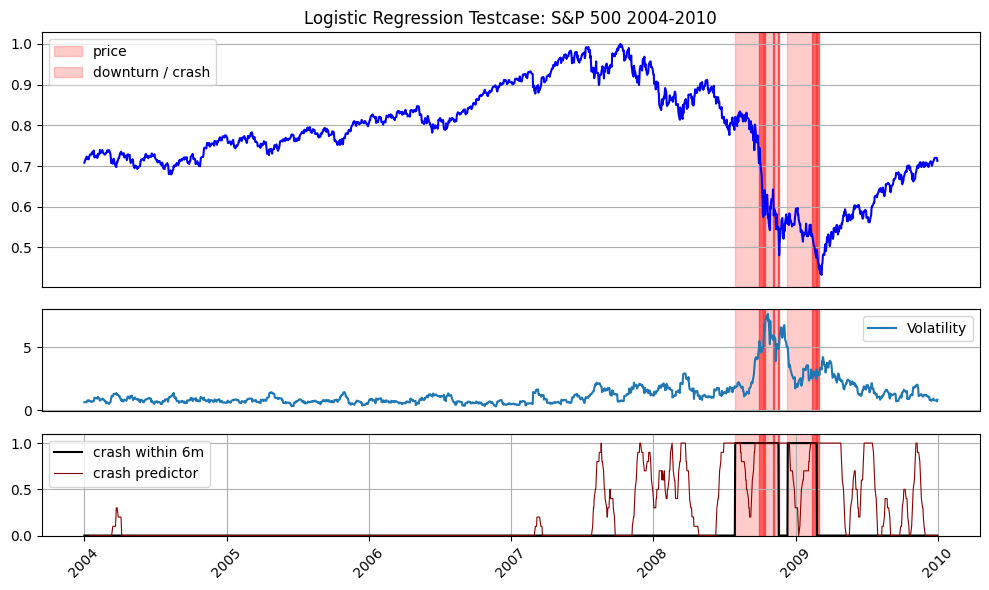

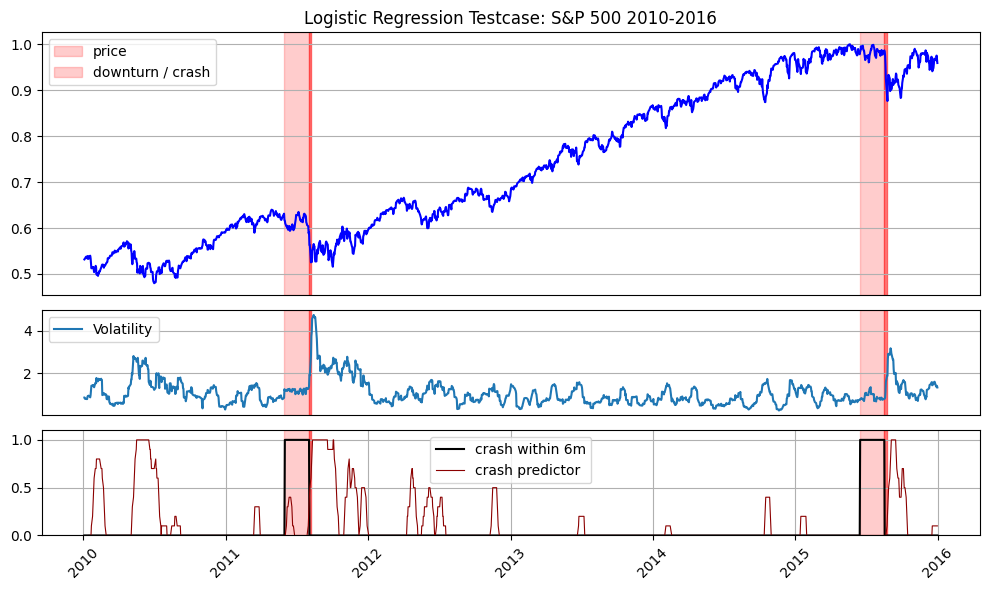

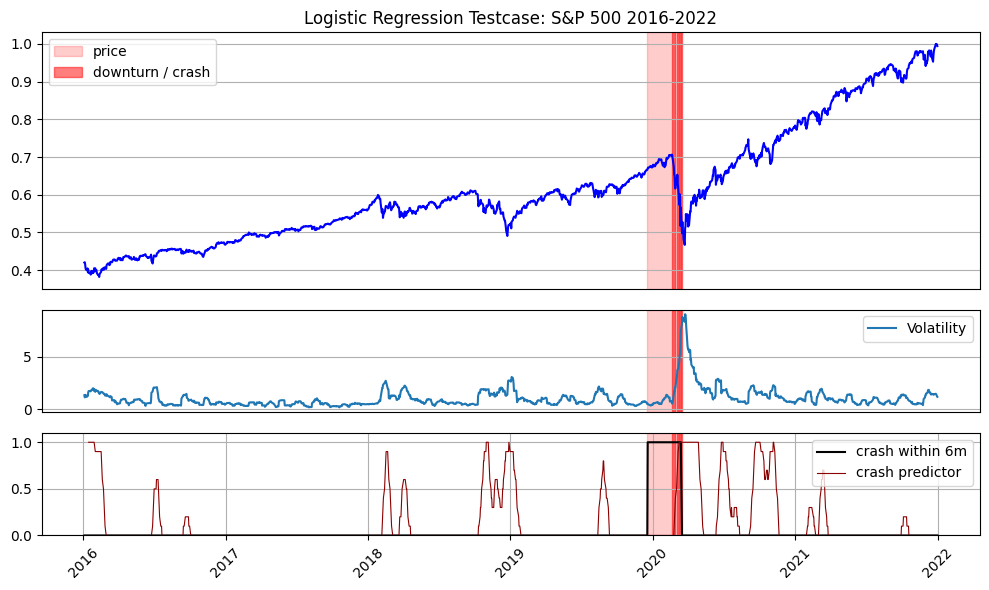

In [7]:
# -------------------- Plot test results -------------------- #
df = datasets_revised[index_test].reindex(dfs_x[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01', '2010-01-01', '2016-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01', '2016-01-01', '2022-01-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)

In [9]:
# -------------------- Current prediction S&P 500 -------------------- #
# train on all available data:
os.chdir('/content/data')
x_train, y_train, _, _ = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data=None)
C = [1, 1, 1]
class_weights = [{0:.06, 1:.94}, {0:.06, 1:.94}, {0:.08, 1:.92}]
dataset_original = ['^GSPC_new.csv']
dataset_name = ['S&P 500']
crash_threshold = [-0.0936]
data_new = DataLoader(dataset_original, dataset_name)
dataset_revised, crashes = data_new.get_data_revised(crash_threshold)
dfs_x_new, dfs_y_new = data_new.get_dfs_xy_predict(months=months)
x_new, _, _, _ = data_new.get_train_test(dfs_x_new, dfs_y_new, dataset_name, test_data=None)

os.chdir('/content/models')
for index_month in range(len(months)):
    y_train_ = y_train[:, index_month].astype(int)
    lm = linear_model.LogisticRegression(C=C[index_month], class_weight=class_weights[index_month])
    model = lm.fit(x_train, y_train_)
    filename = 'logreg_model_{}months.sav'.format(months[index_month])
    pickle.dump(model, open(filename, 'wb'))
    y_pred_new_bin = model.predict(x_new).astype(int)
    current_pred = np.dot(np.linspace(0,1,21) / sum(np.linspace(0,1,21)), y_pred_new_bin[-21:])
    print(str(model_name) + ' prediction of a crash within ' + str(months[index_month]) \
          + ' months: ' + str(np.round(current_pred, 2)))

Logistic Regression prediction of a crash within 1 months: 0.0
Logistic Regression prediction of a crash within 3 months: 0.0
Logistic Regression prediction of a crash within 6 months: 0.0
